In [10]:
# Import libraries
import torch as th
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.auto import trange
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import generate_quantum_dataset as gqd

In [11]:
# sep_data = th.tensor(gqd.generate_states(dimensions = 3,
#                                n_matrices = 4,
#                                n_states = 30000,
#                                entangled = False), dtype=th.complex64)

# ent_data = th.tensor(gqd.generate_states(dimensions = 3,
#                                n_matrices = 4,
#                                n_states = 30000,
#                                entangled = True), dtype=th.complex64)

In [12]:
# th.save(sep_data, '../datasets/sep_states1.pt')
# th.save(ent_data, '../datasets/ent_states1.pt')

In [13]:
# Import datasets

sep_data = th.load('../datasets/sep_states1.pt')

ent_data = th.load('../datasets/ent_states1.pt')

tensor_length = sep_data.shape[1]
print(tensor_length)

sep_data_pair = th.stack((sep_data.real, sep_data.imag), dim=-1).reshape(-1, 1, tensor_length, 2)
ent_data_pair = th.stack((ent_data.real, ent_data.imag), dim=-1).reshape(-1, 1, tensor_length, 2)

# Split the data into training and testing sets

sep_train, sep_test = train_test_split(sep_data_pair, test_size=0.3)
ent_train, ent_test = train_test_split(ent_data_pair, test_size=0.3)

sep_train.shape, sep_test.shape, ent_train.shape, ent_test.shape

81


(torch.Size([21000, 1, 81, 2]),
 torch.Size([9000, 1, 81, 2]),
 torch.Size([21000, 1, 81, 2]),
 torch.Size([9000, 1, 81, 2]))

In [14]:
BATCH_SIZE = 64
ent_train_loader = DataLoader(ent_train, batch_size=BATCH_SIZE, shuffle=True)
ent_test_loader = DataLoader(ent_test, batch_size=BATCH_SIZE, shuffle=True)
sep_train_loader = DataLoader(sep_train, batch_size=BATCH_SIZE, shuffle=True)
sep_test_loader = DataLoader(sep_test, batch_size=BATCH_SIZE, shuffle=True)

In [15]:
# def get_batch_accuracy(logit, target):
#     corrects = (th.max(logit, 1)[1].view(target.size()).data == target.data).sum()
#     accuracy = 100.0 * corrects / target.size(0)
#     return accuracy.item()


# def get_test_stats(model, criterion, test_loader, device):
#     test_acc, test_loss = 0.0, 0.0
#     for _, data in enumerate(test_loader):
#         data = data.to(device)
#         _, decoded = model(data)
#         test_loss += criterion(data, decoded).item()
#         test_acc += get_batch_accuracy(data, decoded)
#         return test_loss, test_acc

def get_test_loss(model, criterion, test_loader, device):
    test_loss = 0.0
    for _, data in enumerate(test_loader):
        data = data.to(device)
        _, decoded = model(data)
        test_loss += criterion(data, decoded).item()
    return test_loss

def train_model(model, train_loader, epochs, optimizer, criterion, device):
    _trained_model = model.to(device)
    _trained_model.train()
    _train_loss = []
    for _ in range(epochs):
        _total_loss = 0.0
        for _, _data in enumerate(train_loader):
            _data = _data.to(device)
            _, _decoded = _trained_model(_data)
            _loss = criterion(_data, _decoded)
            optimizer.zero_grad()
            _loss.backward()
            optimizer.step()
            _total_loss += _loss.item() * _data.size(0)
            
        _train_loss.append(_total_loss / len(train_loader.dataset))
        
    return np.array(_train_loss), _trained_model


def get_decoded_data(model, data_loader, device):
    decoded_data = []
    _trained_model = model.to(device)
    _trained_model.eval()
    for _, data in enumerate(data_loader):
        data = data.to(device)
        _, decoded = _trained_model(data)
        decoded_data.append(decoded.cpu().detach().numpy())
    return np.array(decoded_data)

In [16]:
class VAE_conv(nn.Module):
    def __init__(self, in_channels, dimensions , hidden_size, kernel_size):
        super(VAE_conv, self).__init__()
        self.dim1 = dimensions[0]
        self.dim2 = dimensions[1]
        
        self.conv1 = nn.Conv2d(in_channels = in_channels,
                               out_channels = hidden_size[0],
                               kernel_size = kernel_size[0])
        
        self.dim1 -= (kernel_size[0] - 1)
        self.dim2 -= (kernel_size[0] - 1)
        # print(self.dim1, self.dim2)
        
        if self.dim1 <=0 or self.dim2 <= 0:
            raise ValueError("The kernel size is too large for the input dimensions")

        
        self.conv2 = nn.Conv2d(in_channels = hidden_size[0],
                               out_channels = hidden_size[1],
                               kernel_size = kernel_size[1])
        self.dim1 -= (kernel_size[1] - 1)
        self.dim2 -= (kernel_size[1] - 1)
        # print(self.dim1, self.dim2)
        
        if self.dim1 <=0 or self.dim2 <= 0:
            raise ValueError("The kernel size is too large for the input dimensions")
        
        self.fc1 = nn.Linear(in_features = hidden_size[1] * self.dim1 * self.dim2,
                             out_features = hidden_size[2])
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        
        self.fc2 = nn.Linear(in_features = hidden_size[2], out_features = hidden_size[1] * self.dim1 * self.dim2)
        
        self.conv3 = nn.ConvTranspose2d(in_channels = hidden_size[1],
                                        out_channels = hidden_size[0],
                                        kernel_size = kernel_size[1])
        self.conv4 = nn.ConvTranspose2d(in_channels = hidden_size[0],
                                        out_channels = in_channels,
                                        kernel_size = kernel_size[0])
    
    def encode(self, x):
        # print("init", x.shape)
        x = self.conv1(x)
        # print("conv1", x.shape)
        x = self.LeakyReLU(x)
        
        x = self.conv2(x)
        # print("conv2", x.shape)
        x = self.LeakyReLU(x)
        
        x = x.view(x.shape[0], -1)
        # print("view", x.shape)
        x = self.fc1(x)
        # print("fc1", x.shape)
        
        x = self.LeakyReLU(x)
        return x
    
    def decode(self, x):
        # print("init", x.shape)
        x = self.fc2(x)
        # print("fc2", x.shape)
        x = self.LeakyReLU(x)
        
        x = x.view(x.shape[0], -1, self.dim1, self.dim2)
        # print("view", x.shape)
        
        x = self.conv3(x)
        # print("conv3", x.shape)
        x = self.LeakyReLU(x)
        
        x = self.conv4(x)
        # print("conv4", x.shape)
        # print(x)
        x = self.LeakyReLU(x)
        # print(x)
        return x
        
    
    def forward(self, x):
        encode = self.encode(x)
        decode = self.decode(encode)
        # print(decode)
        return encode, decode
    

model = VAE_conv(in_channels = 1,
                 dimensions=[tensor_length, 2],
                 hidden_size=[int(tensor_length * 0.5), int(tensor_length * 0.25), int(tensor_length * 0.0125)],
                 kernel_size=[1, 1])

for _, data in enumerate(ent_train_loader):
    encoded, decoded = model(data)
    # print(decoded)
    break

In [18]:
model = VAE_conv(in_channels = 1,
                 dimensions=[tensor_length, 2],
                 hidden_size=[int(tensor_length * 0.5), int(tensor_length * 0.25), int(tensor_length * 0.0125)],
                 kernel_size=[1, 1])
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

loss_ent_train, model = train_model(model, ent_train_loader, 10, th.optim.Adam(model.parameters(), lr=1e-3), nn.MSELoss(), device)

th.save(model.state_dict(), 'entangled_model_conv.pt')

In [19]:
ent_losses = np.ndarray(2)
ent_losses[0] = get_test_loss(model, nn.MSELoss(), ent_test_loader, device)
ent_losses[1] = get_test_loss(model, nn.MSELoss(), sep_test_loader, device)

In [20]:
model = VAE_conv(in_channels = 1,
                 dimensions=[tensor_length, 2],
                 hidden_size=[int(tensor_length * 0.5), int(tensor_length * 0.25), int(tensor_length * 0.0125)],
                 kernel_size=[1, 1])
device = th.device('cuda' if th.cuda.is_available() else 'cpu')

loss_sep_train, model = train_model(model, sep_train_loader, 10, th.optim.Adam(model.parameters(), lr=1e-3), nn.MSELoss(), device)

th.save(model.state_dict(), 'separable_model_conv.pt')

In [21]:
sep_losses = np.ndarray(2)
sep_losses[0] = get_test_loss(model, nn.MSELoss(), ent_test_loader, device)
sep_losses[1] = get_test_loss(model, nn.MSELoss(), sep_test_loader, device)

In [22]:
np.min(loss_ent_train), np.min(loss_sep_train)

(2.204638960081086e-05, 5.514248089769224e-06)

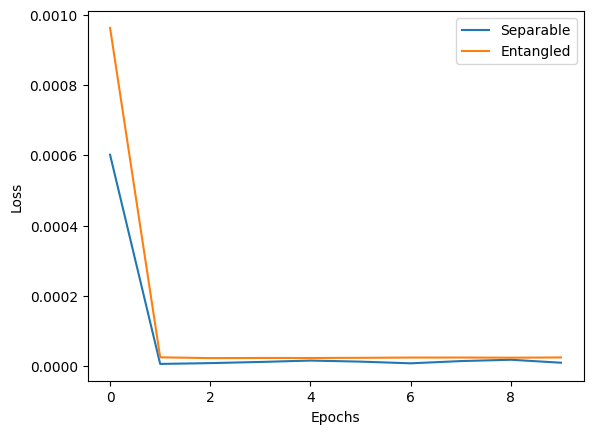

In [23]:
plt.plot(loss_sep_train, label='Separable')
plt.plot(loss_ent_train, label='Entangled')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
# sep_state_dict = th.load('separable_model_conv.pt')
# ent_state_dict = th.load('entangled_model_conv.pt')

# model_sep = VAE_conv(in_channels = 1,
#                      dimensions=[tensor_length, 2],
#                      hidden_size=[int(tensor_length * 0.5), int(tensor_length * 0.25), int(tensor_length * 0.0125)],
#                      kernel_size=[1, 1])
# model_sep.load_state_dict(sep_state_dict)


# model_ent = VAE_conv(in_channels = 1,
#                     dimensions=[tensor_length, 2],
#                     hidden_size=[int(tensor_length * 0.5), int(tensor_length * 0.25), int(tensor_length * 0.0125)],
#                     kernel_size=[1, 1])

# model_ent.load_state_dict(ent_state_dict)


In [ ]:
# ent_loss = []
# sep_loss = []

# ent_loss.append(get_test_loss(model_ent, nn.MSELoss(), ent_test_loader, device))
# ent_loss.append(get_test_loss(model_sep, nn.MSELoss(), ent_test_loader, device))


# sep_loss.append(get_test_loss(model_ent, nn.MSELoss(), sep_test_loader, device))
# sep_loss.append(get_test_loss(model_sep, nn.MSELoss(), sep_test_loader, device))


# ent_loss = np.array(ent_loss)
# sep_loss = np.array(sep_loss)

# ent_loss, sep_loss

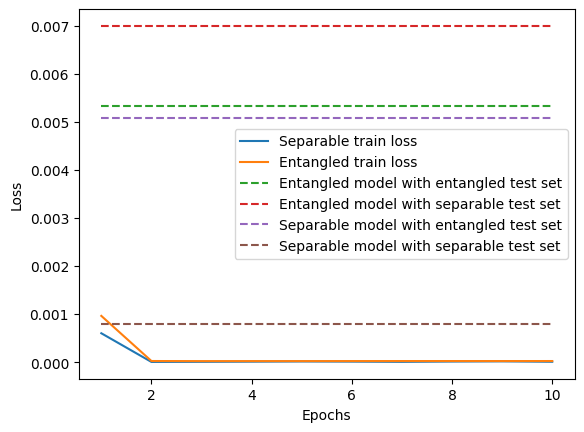

In [24]:
x_axis = np.arange(1, len(loss_ent_train) + 1)

plt.plot(x_axis, loss_sep_train, label='Separable train loss')
plt.plot(x_axis, loss_ent_train, label='Entangled train loss')
plt.plot(x_axis, ent_losses[0] * np.ones(len(x_axis)), label='Entangled model with entangled test set', linestyle= "--")
plt.plot(x_axis, ent_losses[1] * np.ones(len(x_axis)), label='Entangled model with separable test set', linestyle= "--")
plt.plot(x_axis, sep_losses[0] * np.ones(len(x_axis)), label='Separable model with entangled test set', linestyle= "--")
plt.plot(x_axis, sep_losses[1] * np.ones(len(x_axis)), label='Separable model with separable test set', linestyle= "--")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()